# Figure 6 - model fit

This notebook displays the results of the regression model for percent biophony and the sound exposure level (SEL).

#### Import statements

In [1]:
from pymc3 import Model, sample, Normal, Uniform, stats
from pymc3.backends import SQLite
from pymc3.backends.sqlite import load
from os import path

/Users/jake/miniconda3/envs/datawaves/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pandas
import numpy
import seaborn
from figutils import style
from matplotlib import pyplot
%matplotlib inline

#### formatting

In [3]:
style.set_font()

In [7]:
seaborn.set()

#### variable declarations

In [4]:
trace_input_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/model traces/biophony"

In [5]:
trace_input_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/model traces/sel"

In [6]:
data_filepath = "/Users/jake/OneDrive/Documents/alpine soundscapes/data/dataset.csv"

## Load data

In [9]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

In [10]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

In [11]:
column_list = ['sel', 'sel_anthrophony', 'sel_biophony', 'biophony', 'week', 
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'd2n_50m', 'd2n_100m', 'd2n_200m', 'd2n_500m',
    'temperature', 'wind_speed', 'pressure', 'bus_stop',
    'construction', 'crossing', 'cycleway', 'elevator', 'escape', 'footway',
    'living_street', 'motorway', 'motorway_link', 'path', 'pedestrian',
    'platform', 'primary_road', 'primary_link', 'proposed', 'residential',
    'rest_area', 'secondary', 'secondary_link', 'service', 'services',
    'steps', 'tertiary', 'tertiary_link', 'track', 'unclassified', 'combo']

data_centered = data_sorted.copy()
for column in column_list:
    data_centered[column] = data_sorted[column] - data_sorted[column].mean()

## Define and load models for all predictors

In [12]:
sites = numpy.copy(data_sorted.site.values) - 1

In [13]:
site_predictors = [
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'd2n_50m', 'd2n_100m', 'd2n_200m', 'd2n_500m'
]

In [14]:
model1_models = dict()

In [15]:
def define_model1(predictor):
    with Model() as model1:
        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)
    
    return model1

In [16]:
for predictor in site_predictors:
    model1_models[predictor] = define_model1(predictor)

In [17]:
def load_model1(predictor):
    with model1_models[predictor]:
        return load(path.join(trace_input_filepath, 
                              "model1_{0}.sqlite".format(predictor)))

In [18]:
model1_samples = dict()
for predictor in site_predictors:
    model1_samples[predictor] = load_model1(predictor)

## Plot

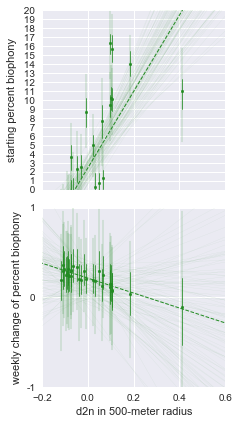

In [24]:
predictor = "d2n_500m"

fig, ax = pyplot.subplots(2, 1, sharex=True, sharey=False)
fig.set_figwidth(3.30)
fig.set_figheight(3.30 * 1.8)
pyplot.subplots_adjust(left=0.19, bottom=0.10, right=0.96, top = 0.98, hspace=0.1, wspace=0)

# organize results
samples = model1_samples[predictor]
model1_data = pandas.DataFrame({'site': data_centered.site.unique(), 
                                 'site_name': data_centered.site_name.unique()}).set_index('site')
model1_data[predictor] = data_centered.groupby('site')[predictor].mean()
model1_data['quantiles_a'] = [stats.quantiles(samples.a[:5000, i]) for i in range(len(set(sites)))]
model1_data['quantiles_b'] = [stats.quantiles(samples.b[:5000, i]) for i in range(len(set(sites)))]

xd = numpy.array([-2, 2])
for d in numpy.random.randint(5000, 9999, 100):
    yd = samples.g_a[d] + (xd * samples.g_as[d])
    ax[0].plot(xd, yd, color='forestgreen', alpha=0.1, linewidth=0.25)

for d in numpy.random.randint(5000, 9999, 100):
    xd = numpy.array([-1, 1])
    yd = samples.g_b[d] + (xd * samples.g_bs[d])
    ax[1].plot(xd, yd, color='forestgreen', alpha=0.1, linewidth=0.25)
    
# plot quantiles
x = model1_data[predictor]

y = [r[50] for r in model1_data['quantiles_a']]
ax[0].scatter(x, y, color='forestgreen', marker='.', zorder=1000, s=30)
ax[0].plot([x, x], [[r[25] for r in model1_data['quantiles_a']], [r[75] for r in model1_data['quantiles_a']]], color='forestgreen', linewidth=0.75)
ax[0].plot([x, x], [[r[2.5] for r in model1_data['quantiles_a']], [r[97.5] for r in model1_data['quantiles_a']]], color='forestgreen', linewidth=0.25)
ax[0].plot(xd, samples.g_a[:5000].mean() + (xd * samples.g_as[:5000].mean()), color='forestgreen', linestyle='--', linewidth=1)

x = model1_data[predictor]
y = [r[50] for r in model1_data['quantiles_b']]
ax[1].scatter(x, y, color='forestgreen', marker='.', zorder=1000, s=30)
ax[1].plot([x, x], [[r[25] for r in model1_data['quantiles_b']], [r[75] for r in model1_data['quantiles_b']]], color='forestgreen', linewidth=0.75)
ax[1].plot([x, x], [[r[2.5] for r in model1_data['quantiles_b']], [r[97.5] for r in model1_data['quantiles_b']]], color='forestgreen', linewidth=0.25)
ax[1].plot(xd, samples.g_b[:5000].mean() + (xd * samples.g_bs[:5000].mean()), color='forestgreen', linestyle='--', linewidth=1)

# format plot
#zero = 0 - data_sorted[predictor].mean()
#xticks = numpy.arange(zero, zero + 2, 0.1)
#xticklabels = [str(n) for n in range(-1, 2, 1)]

#l1 = ax[1].set_xlim([-10, 110])
#lx0 = ax[0].set_xlim([zero, zero + 1])
#lx1 = ax[1].set_xlim([zero, zero + 1])
#ax[0].set_xticks(xticks)
#ax[0].set_xticklabels(xticklabels)
#ax[1].set_xticks(xticks)
#ax[1].set_xticklabels(xticklabels)
#ly0 = ax[0].set_ylim([0, 6])
lx0 = ax[0].set_xlim([-0.2, 0.6])
ly1 = ax[1].set_ylim([-1, 1])
yl0 = ax[0].set_ylabel("starting percent biophony")
xl1 = ax[1].set_xlabel("d2n in 500-meter radius")
yl1 = ax[1].set_ylabel("weekly change of percent biophony")

#ax[0].set_yticklabels = ['-4.0', '-2.0', '0.0', '2.0', '4.0']
zero_y = 0 - data_sorted['biophony'].mean()
ly0 = ax[0].set_ylim([zero_y, zero_y + 20])
yticks = numpy.arange(zero_y, zero_y + 21, 1)
yticklabels = [" {0}".format(n) for n in range(0, 21, 1)]
ly0 = ax[0].set_yticks(yticks)
ly0 = ax[0].set_yticklabels(yticklabels)

lx1 = ax[1].set_xlim([-0.2, 0.6])
yticks = [-1, 0, 1]
yticklabels = [str(n) for n in yticks]
ly1 = ax[1].set_yticks(yticks)
ly1 = ax[1].set_yticklabels(yticks)

#xticks = [-1, 0, 1]
#xticklabels = [str(n) for n in yticks]
#lx1 = ax[1].set_xticks(xticks)
#lx1 = ax[1].set_xticklabels(xticks)

In [21]:
#fig.savefig("/home/ubuntu/download/figure6.tiff", dpi=150)